In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient


import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
client = MongoClient()
db_nba= client.nba
collection = db_nba.player_stats
df_nba = pd.DataFrame(list(collection.find()))

Let's take a high-level look at our dataframe.

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12589 entries, 0 to 12588
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                12589 non-null  object 
 1   Player_ID          12589 non-null  int64  
 2   GROUP_VALUE        12589 non-null  object 
 3   TEAM_ID            12589 non-null  int64  
 4   TEAM_ABBREVIATION  12589 non-null  object 
 5   GP                 12589 non-null  int64  
 6   W                  12589 non-null  int64  
 7   L                  12589 non-null  int64  
 8   FGM                12589 non-null  int64  
 9   FGA                12589 non-null  int64  
 10  FG_PCT             12589 non-null  float64
 11  FG3M               12589 non-null  int64  
 12  FG3A               12589 non-null  int64  
 13  FG3_PCT            12589 non-null  float64
 14  FTM                12589 non-null  int64  
 15  FTA                12589 non-null  int64  
 16  FT_PCT             125

Looks like we can clean this up a bit. 

First, we don't need the '_id' column, as this is a Mongo convention to identify individual entries.
Second, we can rename the 'GROUP_VALUE' column to 'season', based on our knowledge of that column in builder the scrapers.
Lastly, let's convert all column names to lowercase for ease of indexing.

In [4]:
df_nba.drop(columns=['_id'], inplace = True)
df_nba.rename(columns={'GROUP_VALUE':'season'}, inplace = True)

In [5]:
d_lower = dict()
for i in df_nba.columns:
    d_lower[i] = i.lower()

df_nba.rename(columns=d_lower, inplace = True)
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

The last bit of preliminary cleaning will be to get rid of all entries for the 2019-20 season, as the season was stalled, so we won't have any target values. We can do this via indexing.

In [6]:
df_nba.drop(df_nba[df_nba['season'] == '2019-20'].index , inplace=True)

# We first want to investigate the predictivity of regular season wins and playoff berths based on a team roster's individual efficiency ratings from the prior year. 

There are a handful of efficiency metrics that are worth invesitgating here:

Martin Manley's Efficiency ('EFF'): ((Points + Rebounds + Assists + Steals + Blocks) - (Missed Field Goals + Missed Free Throws + Turnovers))/ Games Played

European Performance Index Rating ('PIR'): ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed))/ Games Played

Note: We will not be considering John Hollinger's Player Efficiency Rating ('PER'): It is the most frequently used alternative, however PER is derived by a very complex calculation designed to compensate for different teams' varying style of play, among other factors, and PER scores do not differ markedly from EFF scores.

This study is more so interested in an individual player's efficiency being predictive of team success, regardless of coaching and playing styles. Furthermore, looking at these raw statistics will help inform to what extent a coach should seek to opitimize all individual player efficiencies, or spend a majority of their time tending to star players, or perhaps optimizing other metrics via playing style.

# Let's calculate EFF and PIR's for each player on a per season basis. Then we'll aggregate team rosters on a yearly basis, to eventually offset one season's stats to be fit to the following season's results.

In [7]:
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [8]:
"""EFF = ((Points + Rebounds + Assists + Steals + Blocks) - Missed Field Goals - Missed Free Throws - Turnovers))/ Games Played"""

df_nba['eff'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov']) / df_nba['gp']


"""PIR = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - Missed Field Goals - Missed Free Throws - Turnovers - Shots Rejected - Fouls Committed))/ Games Played"""
df_nba['pir'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']+df_nba['pfd']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov'] \
                 - df_nba['blka'] \
                 - df_nba['pf']) / df_nba['gp']

## Below are the results of our EFF and PIR calculations.

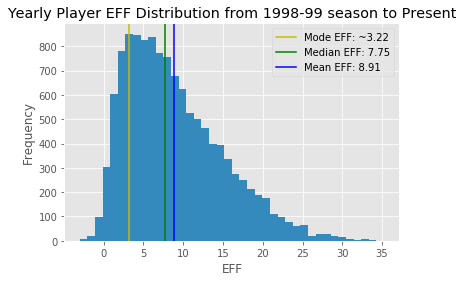

In [9]:
#Calculate all EFF averages and plot histogram to inform distribution

mean_eff = round(np.mean(df_nba['eff']),2)
median_eff = round(np.median(df_nba['eff']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['eff'], bins = 40)
ax.set_title('Yearly Player EFF Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['eff'], bins = 40)[0],ax.hist(df_nba['eff'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_eff = round(np.mean([upper,lower]),2)

ax.axvline(mode_eff, color = 'y', label = f'Mode EFF: ~{mode_eff}')
ax.axvline(median_eff, color = 'g', label = f'Median EFF: {median_eff}')
ax.axvline(mean_eff, color = 'b', label = f'Mean EFF: {mean_eff}')

ax.set_ylabel('Frequency')
ax.set_xlabel('EFF')
ax.legend()


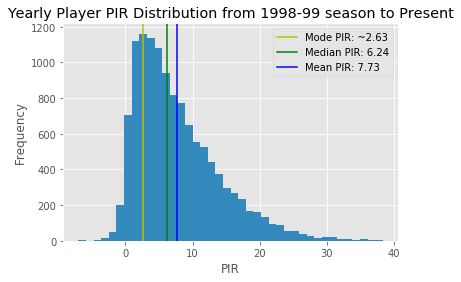

In [10]:
#Calculate all PIR averages and plot histogram to inform distribution

mean_pir = round(np.mean(df_nba['pir']), 2)
median_pir = round(np.median(df_nba['pir']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['pir'], bins = 40)
ax.set_title('Yearly Player PIR Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['pir'], bins = 40)[0],ax.hist(df_nba['pir'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_pir = round(np.mean([upper,lower]),2)

ax.axvline(mode_pir, color = 'y', label = f'Mode PIR: ~{mode_pir}')
ax.axvline(median_pir, color = 'g', label = f'Median PIR: {median_pir}')
ax.axvline(mean_pir, color = 'b', label = f'Mean PIR: {mean_pir}')

ax.set_ylabel('Frequency')
ax.set_xlabel('PIR')
ax.legend()


## Now let's group the data by teams, season, and efficiency to get all of our efficiencies scores in the right place. 

Let's take a second look at our current dataframe. 

First, we'll group the dataframe by players and season. We do this instead of grouping by teams and season, to allow for us to account for roster changes season over season.

We can then reference player_id values for the target season to ensure we're selecting the right features (i.e, player statistics from the previous year, regardless of team affiliation). 

In [11]:
df_by_player = df_nba.groupby(['player_id','season'])
df_by_player.first()

team_id team_abbreviation  gp   w   l  fgm  fga  fg_pct  \
player_id season                                                                
3         1996-97  1610612765               DET  65  41  24  123  275   0.447   
          1997-98  1610612765               DET  40  19  21   50  117   0.427   
          1998-99  1610612737               ATL  50  31  19  151  359   0.421   
          1999-00  1610612763               VAN  42  13  29   74  167   0.443   
          2000-01  1610612763               VAN  66  19  47  140  319   0.439   
...                       ...               ...  ..  ..  ..  ...  ...     ...   
1627734   2017-18  1610612754               IND  74  45  29  340  661   0.514   
          2018-19  1610612754               IND  74  43  31  413  700   0.590   
1627735   2016-17  1610612763               MEM  33  18  15   36  115   0.313   
          2017-18  1610612757               POR   7   4   3   14   21   0.667   
          2018-19  1610612757               POR  16  10   6   10   33   0.303   

                   fg3m  fg3a  ...  tov  stl  blk  blka   pf  pfd   pts  \
player_id season               ...                                        
3         1996-97    17    47  ...   48   43    6    19  106    3   326   
          1997-98     0     4  ...   22   29   12    12   91    3   141   
          1998-99     3    18  ...   74   57   16    25  143    2   489   
          1999-00     0     4  ...   49   45   10     7  108   31   203   
          2000-01     4    15  ...   62   72   15    12  160    1   396   
...                 ...   ...  ...  ...  ...  ...   ...  ...  ...   ...   
1627734   2017-18    13    37  ...  137   40   32    48  220  216   861   
          2018-19     9    17  ...  160   48   30    33  239  287  1043   
1627735   2016-17     3    22  ...   39   18    7    10   40   32   106   
          2017-18     4     5  ...    4    2    1     1   12    7    38   
          2018-19     2     9  ...   14    1    2     5   11    9    30   

                   plus_minus        eff        pir  
player_id season                                     
3         1996-97          69   6.384615   4.507692  
          1997-98          -4   6.300000   3.800000  
          1998-99         205  11.560000   8.240000  
          1999-00         -62   8.976190   6.976190  
          2000-01        -220   8.393939   5.803030  
...                       ...        ...        ...  
1627734   2017-18          34  15.432432  14.729730  
          2018-19         195  20.175676  20.378378  
1627735   2016-17        -139   3.454545   2.909091  
          2017-18           5   5.571429   4.714286  
          2018-19         -66   1.250000   0.812500  

[9888 rows x 28 columns]

## Now, we'll make a second grouped dataframe by team and season.

Team locations and abbreviations have varied throughout the years, however the nba_api has a consistent team_id per franchise, so that's what we'll utilize for sorting purposes.

We'll then index into the df_by_player dataframe based on the ['player_id'] values per team, per season

In [12]:
df_by_team = df_nba.groupby(['team_id','season'])

## For sake of indexing, we need to get all unique team abbreviations and seasons into two separate arrays.

In [19]:
teams = np.unique(df_nba['team_id'])
seasons = np.unique(df_nba['season'])

teams, seasons

seasons = seasons[2:]
seasons

array(['1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04',
       '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10',
       '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16',
       '2016-17', '2017-18', '2018-19'], dtype=object)

Note that the team_id of -1 if for 'TOT' players, or players who were on two or more teams within a given season. 

In [33]:
# Index into each team

for t in teams:
    
    # Index into each season
    for s in seasons:
        
        row = [t,s]
        
        # Create an array to store the statistics in descending order
        new_eff = np.zeros(10)
        for idx,val in enumerate(np.sort(df_by_team.get_group((t,s))['eff'])[::-1]):
            
            if idx < 10:
                new_eff[idx] = val

        
        row = np.concatenate((row, new_eff), axis=None)  
        print(row)

['-1' '1998-99' '19.693877551020407' '17.63888888888889' '17.12'
 '15.795918367346939' '14.785714285714286' '13.75' '12.1'
 '11.131578947368421' '10.926829268292684' '10.595744680851064']
['-1' '1999-00' '14.678571428571429' '12.147058823529411'
 '11.567567567567568' '11.51764705882353' '11.487804878048781'
 '10.62295081967213' '7.903225806451613' '6.982456140350878'
 '5.973684210526316' '5.777777777777778']
['-1' '2000-01' '20.813333333333333' '17.358024691358025'
 '13.891566265060241' '11.707692307692307' '11.615384615384615'
 '11.397435897435898' '11.148148148148149' '10.981132075471699'
 '10.790123456790123' '10.666666666666666']
['-1' '2001-02' '18.03614457831325' '17.81578947368421'
 '17.28205128205128' '16.36111111111111' '15.82716049382716'
 '13.672727272727272' '12.090909090909092' '10.14864864864865'
 '9.452830188679245' '9.216666666666667']
['-1' '2002-03' '21.175' '20.43421052631579' '14.825' '14.523076923076923'
 '14.136363636363637' '12.4' '12.0' '9.732142857142858'
 '9.7

KeyError: (1610612740, '1998-99')